## Hola

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D


class _ArgsWrapper(object):
    """
    Wrapper that allows attribute access to dictionaries
    """
    def __init__(self, args):
        if not isinstance(args, dict):
            args = vars(args)
        self.args = args

    def __getattr__(self, name):
        return self.args.get(name)


def save_model(model, dir, filename, weights_only=False):
    """
    Save Keras model
    :param model:
    :param dir:
    :param filename:
    :param weights_only:
    :return:
    """
    # If target directory does not exist, create
    if not os.path.exists(dir):
        os.makedirs(dir)

    # Construct full path
    filepath = os.path.join(dir, filename)

    if weights_only:
        # Dump model weights
        model.save_weights(filepath)
        print("Model weights were saved to: " + filepath)
    else:
        # Dump model architecture and weights
        model.save(filepath)
        print("Model was saved to: " + filepath)


def load_model(directory, filename, weights_only=False, model=None):
    """
    Loads Keras model
    :param directory:
    :param filename:
    :return:
    """

    # If restoring model weights only, make sure model argument was given
    if weights_only:
        assert model is not None

    # Construct full path to dumped model
    filepath = os.path.join(directory, filename)

    # Check if file exists
    assert os.path.exists(filepath)

    # Return Keras model
    if weights_only:
        result = model.load_weights(filepath)
        print(result)
        return model.load_weights(filepath)
    else:
        return keras.models.load_model(filepath)


def batch_indices(batch_nb, data_length, batch_size):
    """
    This helper function computes a batch start and end index
    :param batch_nb: the batch number
    :param data_length: the total length of the data being parsed by batches
    :param batch_size: the number of inputs in each batch
    :return: pair of (start, end) indices
    """
    # Batch start and end index
    start = int(batch_nb * batch_size)
    end = int((batch_nb + 1) * batch_size)

    # When there are not enough inputs left, we reuse some to complete the
    # batch
    if end > data_length:
        shift = end - data_length
        start -= shift
        end -= shift

    return start, end


def other_classes(nb_classes, class_ind):
    """
    Heper function that returns a list of class indices without one class
    :param nb_classes: number of classes in total
    :param class_ind: the class index to be omitted
    :return: list of class indices without one class
    """

    other_classes_list = list(range(nb_classes))
    other_classes_list.remove(class_ind)

    return other_classes_list


def cnn_model(logits=False, input_ph=None, img_rows=28, img_cols=28,
              channels=1, nb_filters=64, nb_classes=10):
    """
    Defines a CNN model using Keras sequential model
    :param logits: If set to False, returns a Keras model, otherwise will also
                    return logits tensor
    :param input_ph: The TensorFlow tensor for the input
                    (needed if returning logits)
                    ("ph" stands for placeholder but it need not actually be a
                    placeholder)
    :param img_rows: number of row in the image
    :param img_cols: number of columns in the image
    :param channels: number of color channels (e.g., 1 for MNIST)
    :param nb_filters: number of convolutional filters per layer
    :param nb_classes: the number of output classes
    :return:
    """
    model = Sequential()

    if keras.backend.image_dim_ordering() == 'th':
        input_shape = (channels, img_rows, img_cols)
    else:
        input_shape = (img_rows, img_cols, channels)

    layers = [Dropout(0.2, input_shape=input_shape),
              Convolution2D(nb_filters, 8, 8,
                            subsample=(2, 2),
                            border_mode="same"
                            ),
              Activation('relu'),
              Convolution2D(nb_filters * 2, 6, 6, subsample=(2, 2),
                            border_mode="valid"),
              Activation('relu'),
              Convolution2D(nb_filters * 2, 5, 5, subsample=(1, 1)),
              Activation('relu'),
              Dropout(0.5),
              Flatten(),
              Dense(nb_classes)]
    for layer in layers:
        model.add(layer)
    if logits:
        logits_tensor = model(input_ph)
    model.add(Activation('softmax'))

    if logits:
        return model, logits_tensor
    else:
        return model


def pair_visual(original, adversarial, figure=None):
    """
    This function displays two images: the original and the adversarial sample
    :param original: the original input
    :param adversarial: the input after perterbations have been applied
    :param figure: if we've already displayed images, use the same plot
    :return: the matplot figure to reuse for future samples
    """

    # Ensure our inputs are of proper shape
    assert(len(original.shape) == 2 or len(original.shape) == 3)

    # To avoid creating figures per input sample, reuse the sample plot
    if figure is None:
        plt.ion()
        figure = plt.figure()
        figure.canvas.set_window_title('Cleverhans: Pair Visualization')

    # Add the images to the plot
    perterbations = adversarial - original
    for index, image in enumerate((original, perterbations, adversarial)):
        figure.add_subplot(1, 3, index + 1)
        plt.axis('off')

        # If the image is 2D, then we have 1 color channel
        if len(image.shape) == 2:
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)

        # Give the plot some time to update
        plt.pause(0.01)

    # Draw the plot and return
    plt.show()
    return figure


def grid_visual(data):
    """
    This function displays a grid of images to show full misclassification
    :param data: grid data of the form;
        [nb_classes : nb_classes : img_rows : img_cols : nb_channels]
    :return: if necessary, the matplot figure to reuse
    """

    # Ensure interactive mode is disabled and initialize our graph
    plt.ioff()
    figure = plt.figure()
    figure.canvas.set_window_title('Cleverhans: Grid Visualization')

    # Add the images to the plot
    num_cols = data.shape[0]
    num_rows = data.shape[1]
    num_channels = data.shape[4]
    current_row = 0
    for y in xrange(num_rows):
        for x in xrange(num_cols):
            figure.add_subplot(num_cols, num_rows, (x+1)+(y*num_rows))
            plt.axis('off')

            if num_channels == 1:
                plt.imshow(data[x, y, :, :, 0], cmap='gray')
            else:
                plt.imshow(data[x, y, :, :, :])

    # Draw the plot and return
    plt.show()
    return figure


Using TensorFlow backend.


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import keras
import math
import numpy as np
import os
import six
import tensorflow as tf
import time
import warnings

from tensorflow.python.platform import flags

FLAGS = flags.FLAGS


class _FlagsWrapper(_ArgsWrapper):
    """
    Wrapper that tries to find missing parameters in TensorFlow FLAGS
    for backwards compatibility.

    Plain _ArgsWrapper should be used instead if the support for FLAGS
    is removed.
    """
    def __getattr__(self, name):
        val = self.args.get(name)
        if val is None:
            warnings.warn('Setting parameters ({}) from TensorFlow FLAGS is '
                          'deprecated.'.format(name))
            val = FLAGS.__getattr__(name)
        return val


def model_loss(y, model, mean=True):
    """
    Define loss of TF graph
    :param y: correct labels
    :param model: output of the model
    :param mean: boolean indicating whether should return mean of loss
                 or vector of losses for each input of the batch
    :return: return mean of loss if True, otherwise return vector with per
             sample loss
    """

    op = model.op
    if "softmax" in str(op).lower():
        logits, = op.inputs
    else:
        logits = model

    out = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)

    if mean:
        out = tf.reduce_mean(out)
    return out


def tf_model_train(*args, **kwargs):
    warnings.warn("`tf_model_train` is deprecated. Switch to `model_train`."
                  "`tf_model_train` will be removed after 2017-07-18.")
    return model_train(*args, **kwargs)


def model_train(sess, x, y, predictions, X_train, Y_train, save=False,
                predictions_adv=None, evaluate=None, verbose=True, args=None):
    """
    Train a TF graph
    :param sess: TF session to use when training the graph
    :param x: input placeholder
    :param y: output placeholder (for labels)
    :param predictions: model output predictions
    :param X_train: numpy array with training inputs
    :param Y_train: numpy array with training outputs
    :param save: boolean controling the save operation
    :param predictions_adv: if set with the adversarial example tensor,
                            will run adversarial training
    :param args: dict or argparse `Namespace` object.
                 Should contain `nb_epochs`, `learning_rate`,
                 `batch_size`
                 If save is True, should also contain 'train_dir'
                 and 'filename'
    :return: True if model trained
    """
    args = _FlagsWrapper(args or {})

    # Check that necessary arguments were given (see doc above)
    assert args.nb_epochs, "Number of epochs was not given in args dict"
    assert args.learning_rate, "Learning rate was not given in args dict"
    assert args.batch_size, "Batch size was not given in args dict"

    if save:
        assert args.train_dir, "Directory for save was not given in args dict"
        assert args.filename, "Filename for save was not given in args dict"

    # Define loss
    loss = model_loss(y, predictions)
    if predictions_adv is not None:
        loss = (loss + model_loss(y, predictions_adv)) / 2

    train_step = tf.train.AdadeltaOptimizer(learning_rate=args.learning_rate,
                                            rho=0.95,
                                            epsilon=1e-08).minimize(loss)

    with sess.as_default():
        tf.global_variables_initializer().run()
        """if hasattr(tf, "global_variables_initializer"):
            tf.global_variables_initializer().run()
        else:
            warnings.warn("Update your copy of tensorflow; future versions of "
                          "cleverhans may drop support for this version.")
            sess.run(tf.initialize_all_variables())"""

        for epoch in six.moves.xrange(args.nb_epochs):
            if verbose:
                print("Epoch " + str(epoch))

            # Compute number of batches
            nb_batches = int(math.ceil(float(len(X_train)) / args.batch_size))
            assert nb_batches * args.batch_size >= len(X_train)

            prev = time.time()
            for batch in range(nb_batches):

                # Compute batch start and end indices
                start, end = batch_indices(
                    batch, len(X_train), args.batch_size)

                # Perform one training step
                train_step.run(feed_dict={x: X_train[start:end],
                                          y: Y_train[start:end],
                                          keras.backend.learning_phase(): 1})
            assert end >= len(X_train)  # Check that all examples were used
            cur = time.time()
            if verbose:
                print("\tEpoch took " + str(cur - prev) + " seconds")
            prev = cur
            if evaluate is not None:
                evaluate()

        if save:
            save_path = os.path.join(args.train_dir, args.filename)
            saver = tf.train.Saver()
            saver.save(sess, save_path)
            print("Completed model training and model saved at:"
                  + str(save_path))
        else:
            print("Completed model training.")

    return True


def tf_model_eval(*args, **kwargs):
    warnings.warn("`tf_model_eval` is deprecated. Switch to `model_eval`."
                  "`tf_model_eval` will be removed after 2017-07-18.")
    return model_eval(*args, **kwargs)


def model_eval(sess, x, y, model, X_test, Y_test, args=None):
    """
    Compute the accuracy of a TF model on some data
    :param sess: TF session to use when training the graph
    :param x: input placeholder
    :param y: output placeholder (for labels)
    :param model: model output predictions
    :param X_test: numpy array with training inputs
    :param Y_test: numpy array with training outputs
    :param args: dict or argparse `Namespace` object.
                 Should contain `batch_size`
    :return: a float with the accuracy value
    """
    args = _FlagsWrapper(args or {})

    assert args.batch_size, "Batch size was not given in args dict"

    # Define symbol for accuracy
    acc_value = keras.metrics.categorical_accuracy(y, model)

    # Init result var
    accuracy = 0.0

    with sess.as_default():
        # Compute number of batches
        nb_batches = int(math.ceil(float(len(X_test)) / args.batch_size))
        assert nb_batches * args.batch_size >= len(X_test)

        for batch in range(nb_batches):
            if batch % 100 == 0 and batch > 0:
                print("Batch " + str(batch))

            # Must not use the `batch_indices` function here, because it
            # repeats some examples.
            # It's acceptable to repeat during training, but not eval.
            start = batch * args.batch_size
            end = min(len(X_test), start + args.batch_size)
            cur_batch_size = end - start

            # The last batch may be smaller than all others, so we need to
            # account for variable batch size here
            accuracy += cur_batch_size * acc_value.eval(
                feed_dict={x: X_test[start:end],
                           y: Y_test[start:end],
                           keras.backend.learning_phase(): 0})
        assert end >= len(X_test)

        # Divide by number of examples to get final value
        accuracy /= len(X_test)

    return accuracy


def tf_model_load(sess):
    """

    :param sess:
    :param x:
    :param y:
    :param model:
    :return:
    """
    with sess.as_default():
        saver = tf.train.Saver()
        saver.restore(sess, os.path.join(FLAGS.train_dir, FLAGS.filename))

    return True


def batch_eval(sess, tf_inputs, tf_outputs, numpy_inputs, args=None):
    """
    A helper function that computes a tensor on numpy inputs by batches.

    :param sess:
    :param tf_inputs:
    :param tf_outputs:
    :param numpy_inputs:
    :param args: dict or argparse `Namespace` object.
                 Should contain `batch_size`
    """
    args = _FlagsWrapper(args or {})

    assert args.batch_size, "Batch size was not given in args dict"

    n = len(numpy_inputs)
    assert n > 0
    assert n == len(tf_inputs)
    m = numpy_inputs[0].shape[0]
    for i in six.moves.xrange(1, n):
        assert numpy_inputs[i].shape[0] == m
    out = []
    for _ in tf_outputs:
        out.append([])
    with sess.as_default():
        for start in six.moves.xrange(0, m, args.batch_size):
            batch = start // args.batch_size
            if batch % 100 == 0 and batch > 0:
                print("Batch " + str(batch))

            # Compute batch start and end indices
            start = batch * args.batch_size
            end = start + args.batch_size
            numpy_input_batches = [numpy_input[start:end]
                                   for numpy_input in numpy_inputs]
            cur_batch_size = numpy_input_batches[0].shape[0]
            assert cur_batch_size <= args.batch_size
            for e in numpy_input_batches:
                assert e.shape[0] == cur_batch_size

            feed_dict = dict(zip(tf_inputs, numpy_input_batches))
            feed_dict[keras.backend.learning_phase()] = 0
            numpy_output_batches = sess.run(tf_outputs, feed_dict=feed_dict)
            for e in numpy_output_batches:
                assert e.shape[0] == cur_batch_size, e.shape
            for out_elem, numpy_output_batch in zip(out, numpy_output_batches):
                out_elem.append(numpy_output_batch)

    out = [np.concatenate(x, axis=0) for x in out]
    for e in out:
        assert e.shape[0] == m, e.shape
    return out


def model_argmax(sess, x, predictions, sample):
    """
    Helper function that computes the current class prediction
    :param sess: TF session
    :param x: the input placeholder
    :param predictions: the model's symbolic output
    :param sample: (1 x 1 x img_rows x img_cols) numpy array with sample input
    :return: the argmax output of predictions, i.e. the current predicted class
    """

    feed_dict = {x: sample, keras.backend.learning_phase(): 0}
    probabilities = sess.run(predictions, feed_dict)

    return np.argmax(probabilities)


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import keras
from keras.datasets import mnist
from keras.utils import np_utils
import warnings


def data_mnist():
    """
    Preprocess MNIST dataset
    :return:
    """

    # These values are specific to MNIST
    img_rows = 28
    img_cols = 28
    nb_classes = 10

    # the data, shuffled and split between train and test sets
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    if keras.backend.image_dim_ordering() == 'th':
        X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
        X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    else:
        X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
        X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    return X_train, Y_train, X_test, Y_test


def model_mnist(logits=False, input_ph=None, img_rows=28, img_cols=28,
                nb_filters=64, nb_classes=10):
    warnings.warn("`utils_mnist.model_mnist` is deprecated. Switch to"
                  "`utils.cnn_model`. `utils_mnist.model_mnist` will "
                  "be removed after 2017-08-17.")
    return utils.cnn_model(logits=logits, input_ph=input_ph,
                           img_rows=img_rows, img_cols=img_cols,
                           nb_filters=nb_filters, nb_classes=nb_classes)


In [4]:
def fgsm(x, predictions, eps, clip_min=None, clip_max=None):
    """
    TensorFlow implementation of the Fast Gradient
    Sign method.
    :param x: the input placeholder
    :param predictions: the model's output tensor
    :param eps: the epsilon (input variation parameter)
    :param clip_min: optional parameter that can be used to set a minimum
                    value for components of the example returned
    :param clip_max: optional parameter that can be used to set a maximum
                    value for components of the example returned
    :return: a tensor for the adversarial example
    """

    # Compute loss
    #print("PREDICTIONS")
    #print(predictions.eval())
    #print(tf.reduce_max(predictions, 1, keep_dims=True))
    y = tf.to_float(
        tf.equal(predictions, tf.reduce_max(predictions, 1, keep_dims=True)))
    y = y / tf.reduce_sum(y, 1, keep_dims=True)
    loss = model_loss(y, predictions, mean=False)

    # Define gradient of loss wrt input
    grad, = tf.gradients(loss, x)

    # Take sign of gradient
    signed_grad = tf.sign(grad)

    # Multiply by constant epsilon
    scaled_signed_grad = eps * signed_grad

    # Add perturbation to original example to obtain adversarial example
    adv_x = tf.stop_gradient(x + scaled_signed_grad)

    # If clipping is needed, reset all values outside of [clip_min, clip_max]
    if (clip_min is not None) and (clip_max is not None):
        adv_x = tf.clip_by_value(adv_x, clip_min, clip_max)

    return adv_x

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import keras
from keras import backend

import tensorflow as tf
from tensorflow.python.platform import app
from tensorflow.python.platform import flags

FLAGS = flags.FLAGS

flags.DEFINE_integer('nb_epochs', 6, 'Number of epochs to train model')
flags.DEFINE_integer('batch_size', 128, 'Size of training batches')
flags.DEFINE_float('learning_rate', 0.1, 'Learning rate for training')

In [6]:
# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)

In [7]:
if not hasattr(backend, "tf"):
    raise RuntimeError("This tutorial requires keras to be configured" 
                           " to use the TensorFlow backend.")


In [8]:
# Image dimensions ordering should follow the Theano convention
if keras.backend.image_dim_ordering() != 'tf':
    keras.backend.set_image_dim_ordering('tf')
    print("INFO: '~/.keras/keras.json' sets 'image_dim_ordering' to "
            "'th', temporarily setting to 'tf'")

In [9]:
# Create TF session and set as Keras backend session
sess = tf.Session()
keras.backend.set_session(sess)

In [10]:
# Get MNIST test data
X_train, Y_train, X_test, Y_test = data_mnist()

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [11]:
type(Y_train)

numpy.ndarray

In [12]:
assert Y_train.shape[1] == 10.
label_smooth = .1
Y_train = Y_train.clip(label_smooth / 9., 1. - label_smooth)

In [13]:
Y_train[0:2]

array([[ 0.01111111,  0.01111111,  0.01111111,  0.01111111,  0.01111111,
         0.9       ,  0.01111111,  0.01111111,  0.01111111,  0.01111111],
       [ 0.9       ,  0.01111111,  0.01111111,  0.01111111,  0.01111111,
         0.01111111,  0.01111111,  0.01111111,  0.01111111,  0.01111111]])

In [14]:
# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
y = tf.placeholder(tf.float32, shape=(None, 10))

In [15]:
# Define TF model graph
model = cnn_model()
predictions = model(x)
print("Defined TensorFlow model graph.")

Defined TensorFlow model graph.


In [16]:
def evaluate():
    # Evaluate the accuracy of the MNIST model on legitimate test examples
    eval_params = {'batch_size': FLAGS.batch_size}
    accuracy = model_eval(sess, x, y, predictions, X_test, Y_test,
                          args=eval_params)
    assert X_test.shape[0] == 10000, X_test.shape
    print('Test accuracy on legitimate test examples: ' + str(accuracy))

In [17]:
# Train an MNIST model
train_params = {
    'nb_epochs': FLAGS.nb_epochs,
    'batch_size': FLAGS.batch_size,
    'learning_rate': FLAGS.learning_rate
}

model_train(sess, x, y, predictions, X_train, Y_train, evaluate=evaluate, args=train_params)

Epoch 0
	Epoch took 44.010509729385376 seconds
Test accuracy on legitimate test examples: 0.9244
Epoch 1
	Epoch took 43.45127630233765 seconds
Test accuracy on legitimate test examples: 0.9479
Epoch 2
	Epoch took 43.71137714385986 seconds
Test accuracy on legitimate test examples: 0.9586
Epoch 3
	Epoch took 43.88304424285889 seconds
Test accuracy on legitimate test examples: 0.9645
Epoch 4
	Epoch took 46.80714440345764 seconds
Test accuracy on legitimate test examples: 0.9703
Epoch 5
	Epoch took 45.878817558288574 seconds
Test accuracy on legitimate test examples: 0.9727
Completed model training.


True

In [18]:
# Craft adversarial examples using Fast Gradient Sign Method (FGSM)
adv_x = fgsm(x, predictions, eps=0.3)
eval_params = {'batch_size': FLAGS.batch_size}

In [19]:
X_test_adv, = batch_eval(sess, [x], [adv_x], [X_test], args=eval_params)

In [20]:
X_test_adv[:1]

array([[[[ 0.30000001],
         [ 0.30000001],
         [ 0.30000001],
         [ 0.30000001],
         [ 0.30000001],
         [ 0.30000001],
         [ 0.30000001],
         [ 0.30000001],
         [ 0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001]],

        [[ 0.30000001],
         [ 0.30000001],
         [ 0.30000001],
         [ 0.30000001],
         [ 0.30000001],
         [ 0.30000001],
         [ 0.30000001],
         [ 0.30000001],
         [ 0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.30000001],
         [-0.3

In [21]:
X_test[:1]

array([[[[ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        [[ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0. 

In [22]:
print(tf.reduce_max(predictions.eval({x:X_test, keras.backend.learning_phase():0}, session=sess), 1, keep_dims=True).eval(session=sess))

[[ 0.91850078]
 [ 0.93933558]
 [ 0.89378422]
 ..., 
 [ 0.93386763]
 [ 0.93458962]
 [ 0.93732846]]


In [23]:
print(predictions.eval({x:X_test, keras.backend.learning_phase():0}, session=sess))

[[  1.16804680e-02   1.00518307e-02   1.16472468e-02 ...,   9.18500781e-01
    3.87454638e-03   8.72335583e-03]
 [  1.03251608e-02   1.17031988e-02   9.39335585e-01 ...,   1.40797033e-03
    5.79976942e-03   3.27410223e-03]
 [  1.38113210e-02   8.93784225e-01   9.21671465e-03 ...,   1.35107990e-02
    7.43264705e-03   8.18998646e-03]
 ..., 
 [  5.21284202e-03   5.76444110e-03   3.11589311e-03 ...,   7.52498815e-03
    6.98998058e-03   2.63973009e-02]
 [  3.49080935e-03   1.54837698e-03   8.96481914e-04 ...,   6.61458168e-03
    2.76952405e-02   2.81033269e-03]
 [  9.17047542e-03   8.61044507e-03   8.01769365e-03 ...,   5.21927467e-03
    3.09171504e-03   4.95432364e-03]]


In [24]:
# Evaluate the accuracy of the MNIST model on adversarial examples
accuracy = model_eval(sess, x, y, predictions, np.array([X_test_adv[0]]), np.array([Y_test[0]]),
                          args=eval_params)
print('Test accuracy on adversarial examples: ' + str(accuracy))

Test accuracy on adversarial examples: 0.0


In [25]:
predictions.eval({x:np.array([X_test_adv[0]]), keras.backend.learning_phase():0}, session=sess)

array([[ 0.03016986,  0.03341802,  0.24376959,  0.14268301,  0.03944839,
         0.06488139,  0.01809699,  0.01743182,  0.37487182,  0.03522912]], dtype=float32)

In [26]:
Y_test[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])

In [27]:
import matplotlib.pyplot as plt

In [28]:
%matplotlib inline

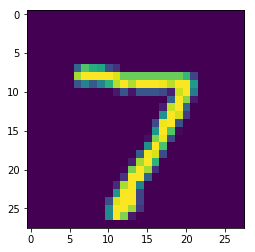

In [29]:
plt.imshow(np.array(X_test[0]).reshape(28,28))

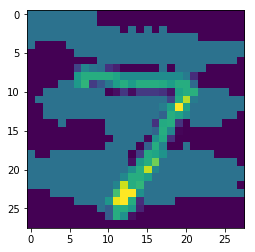

In [30]:
plt.imshow(np.array(X_test_adv[0]).reshape(28,28))

In [31]:
# Evaluate the accuracy of the MNIST model on adversarial examples
accuracy = model_eval(sess, x, y, predictions, X_test_adv, Y_test,
                          args=eval_params)
print('Test accuracy on adversarial examples: ' + str(accuracy))

Test accuracy on adversarial examples: 0.0217


In [32]:
print("Repeating the process, using adversarial training")
# Redefine TF model graph
model_2 = cnn_model()
predictions_2 = model_2(x)
adv_x_2 = fgsm(x, predictions_2, eps=0.3)
predictions_2_adv = model_2(adv_x_2)

Repeating the process, using adversarial training


In [33]:
def evaluate_2():
        # Evaluate the accuracy of the adversarialy trained MNIST model on
        # legitimate test examples
        eval_params = {'batch_size': FLAGS.batch_size}
        accuracy = model_eval(sess, x, y, predictions_2, X_test, Y_test,
                              args=eval_params)
        print('Test accuracy on legitimate test examples: ' + str(accuracy))

        # Evaluate the accuracy of the adversarially trained MNIST model on
        # adversarial examples
        accuracy_adv = model_eval(sess, x, y, predictions_2_adv, X_test,
                                  Y_test, args=eval_params)
        print('Test accuracy on adversarial examples: ' + str(accuracy_adv))

In [34]:
# Train an MNIST model
train_params = {
    'nb_epochs': 10,
    'batch_size': FLAGS.batch_size,
    'learning_rate': FLAGS.learning_rate
}

    
# Perform adversarial training
model_train(sess, x, y, predictions_2, X_train, Y_train,
            predictions_adv=predictions_2_adv, evaluate=evaluate_2,
            args=train_params)

Epoch 0
	Epoch took 100.55715894699097 seconds
Test accuracy on legitimate test examples: 0.9233
Test accuracy on adversarial examples: 0.2316
Epoch 1
	Epoch took 100.49397683143616 seconds
Test accuracy on legitimate test examples: 0.952
Test accuracy on adversarial examples: 0.347
Epoch 2
	Epoch took 100.8620274066925 seconds
Test accuracy on legitimate test examples: 0.9602
Test accuracy on adversarial examples: 0.3996
Epoch 3
	Epoch took 100.36771154403687 seconds
Test accuracy on legitimate test examples: 0.9639
Test accuracy on adversarial examples: 0.4343
Epoch 4
	Epoch took 100.47701644897461 seconds
Test accuracy on legitimate test examples: 0.9672
Test accuracy on adversarial examples: 0.4687
Epoch 5
	Epoch took 100.33534026145935 seconds
Test accuracy on legitimate test examples: 0.9695
Test accuracy on adversarial examples: 0.5056
Epoch 6
	Epoch took 101.85268974304199 seconds
Test accuracy on legitimate test examples: 0.9722
Test accuracy on adversarial examples: 0.5431
Ep

True

In [35]:
X_test_adv_2, = batch_eval(sess, [x], [adv_x_2], [X_test], args=eval_params)

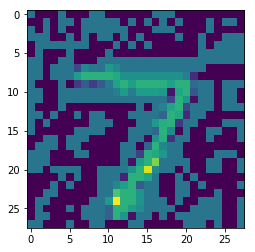

In [36]:
plt.imshow(X_test_adv_2[0].reshape(28,28))

In [37]:
# Evaluate the accuracy of the MNIST model on adversarial examples
accuracy = model_eval(sess, x, y, predictions_2_adv, np.array([X_test_adv_2[0]]), np.array([Y_test[0]]),
                          args=eval_params)
print('Test accuracy on adversarial examples: ' + str(accuracy))

Test accuracy on adversarial examples: 0.0


In [38]:
predictions_2_adv.eval({x:np.array([X_test_adv_2[0]]),keras.backend.learning_phase():0}, session=sess)

array([[ 0.02298293,  0.02284614,  0.01305325,  0.19911435,  0.02017662,
         0.62100452,  0.01645812,  0.02117987,  0.03327766,  0.02990649]], dtype=float32)

In [39]:
# Evaluate the accuracy of the MNIST model on adversarial examples
accuracy = model_eval(sess, x, y, predictions_2_adv, X_test_adv_2, Y_test,
                          args=eval_params)
print('Test accuracy on adversarial examples: ' + str(accuracy))

Test accuracy on adversarial examples: 0.1305
